Here, we will be working with following dataset:

- Maguire, M., Dorafshan, S., & Thomas, R. J. (2018). SDNET2018: A concrete crack image dataset for machine learning applications. Utah State University. https://doi.org/10.15142/T3TD19

Specifically, we will only work with wall images from the above data set. The data set in total contains 18138 images of walls and the goal is to predict if the wall in an image has a crack. In only 3851 of the images the wall has a crack, while in 14287 images it has not, meaning the data set is slightly imbalanced. The original papers cited above state in following publication:
- Dorafshan, S., & Thomas, R. J., Maguire, M. (2018). SDNET2018: An annotated image dataset for non-contact concrete crack detection using deep convolutional neural networks. Data in Brief, 21, 1664-1668. https://doi.org/10.1016/j.dib.2018.11.015

...that AlexNet yielded an accuracy of 87.5% on this dataset.

See also following notebook for more impressions of the dataset:
- https://github.com/cstckr/SimCLR_contrastive_learning/blob/main/SimCLR.ipynb


The goal of this notebook is to establish a baseline that is subsequently to be compared to other models / techniques. Transfer or self-supervised pretraining is not in the scope of this notebook.

Some short remarks on the approach used in this notebook:
- A model consisting of residual blocks with preactivation (see He, Zhang, Ren, Sun, Identity Mappings in Deep Residual Networks. https://arxiv.org/pdf/1603.05027.pdf)
- For the learning rate, the tensorflow.keras.callbacks.ReduceLROnPlateau schedule is expanded so that the learning rate is restarted after a certain
number of reducing steps.
- Incorporation of DropPath for regularization (see Larsson, Maire, Shakhnarovich, FractalNet: Ultra-Deep Neural Networks Without Residuals. https://arxiv.org/pdf/1605.07648v4.pdf)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.layers import (
    Dense, Dropout, Conv2D, Add, Activation, Input, BatchNormalization, 
    GlobalMaxPooling2D, MaxPooling2D, Layer)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay)
import albumentations as A
import random
import ssl
import urllib
import zipfile
import os
from PIL import Image
from functools import partial

random.seed(42)
tf.random.set_seed(42)

devices = tf.config.list_physical_devices("GPU") 
for gpu in devices:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Variables and hyperparameters

input_shape = (256, 256, 3)
filters = [64, 128, 128, 256, 256, 512] 
kernels = [256, 256]
droppath_prob = 0.03
batch_size = 64

epochs = 125
patience_early_stopping = 30

lr_initial = 3e-4
lr_decay = 0.97
patience_lr = 4
factor_reduce = 0.25
factor_restart = 1.2
max_lr_restart = lr_initial * 2
restart_after_x_reductions = 1
increment_restart_after_x_reductions = 1

In [3]:
# Custom functions and classes

class DropPath(Layer):
  def __init__(self, droppath_prob=None, **kwargs):
    super().__init__(**kwargs)
    self.drop_prob = droppath_prob

  def call(self, x, training=None):
    if self.drop_prob == 0 or training==False:
      return x
    if training is None:
      training = tf.keras.backend.learning_phase()
    if training:
      shape = (tf.shape(x)[0],) + (1,) * (x.shape.rank - 1)
      mask = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
      mask = tf.floor(mask)
      x = (x / (1 - self.drop_prob)) * mask
    return x


class Residual(Layer):
  def __init__(self, filters, droppath_prob, initializer, **kwargs):
    super().__init__(**kwargs)
    self.activation = Activation("relu")
    self.bn1 = BatchNormalization()
    self.bn2 = BatchNormalization()
    self.bn3 = BatchNormalization()
    self.conv1 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), 
                       padding="same", kernel_initializer=initializer)
    self.conv2 = Conv2D(filters=filters//2, kernel_size=(1, 1), strides=(1, 1), 
                        padding="same", kernel_initializer=initializer)
    self.conv3 = Conv2D(filters=filters//2, kernel_size=(3, 3), strides=(1, 1), 
                        padding="same", kernel_initializer=initializer)
    self.conv4 = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), 
                        padding="same", kernel_initializer=initializer)
    self.droppath = DropPath(droppath_prob)

  def call(self, x):
    x = self.bn1(x)
    x = self.activation(x)
    x_skip = self.conv1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.activation(x)
    x = self.conv4(x)
    x = self.droppath(x)

    x = x_skip + x
    return x


def split_data(data, train_ratio, val_ratio):
  test_ratio = 1 - train_ratio - val_ratio
  no_train_samples = int(len(data) * train_ratio)
  no_test_samples =  int(len(data) * test_ratio)
  
  train_data = random.sample(data, no_train_samples)
  val_data = [x for x in data if x not in train_data]
  test_data = random.sample(val_data, no_test_samples)
  val_data = [x for x in val_data if x not in test_data]
  return train_data, val_data, test_data


def get_data(file_paths, augment):
  for file_path in file_paths:
    img = np.array(Image.open(file_path), dtype=np.float32) / 255

    if augment:
      transform = A.Compose([
          A.HorizontalFlip(p=0.3),
          A.VerticalFlip(p=0.3),
          A.Compose([
              A.RandomCrop(
                  width=int(img.shape[1] * random.uniform(0.9, 1)), 
                  height=int(img.shape[0] * random.uniform(0.9, 1))),
                A.Resize(img.shape[0], img.shape[1])], p=0.3),
          A.ColorJitter(p=0.3)])
      transformed = transform(image=img)
      img = transformed["image"]

    if "CW" in file_path:
      y = np.array([0])
    elif "UW" in file_path:
      y = np.array([1])
    yield img, y


class CNN001(Model):
  def __init__(self, input_shape, filters, kernels, droppath_prob, seed=42):
    super().__init__()
    self.initializer = tf.keras.initializers.HeNormal(seed=seed)

    self.encoder = self._create_encoder(input_shape, filters, droppath_prob)
    self.ffn = self._create_ffn(
        np.array(self.encoder.layers[-1].output.shape[1:]), kernels)
    self.classifier = self._create_classifier(
        np.array(self.ffn.layers[-1].output.shape[1:]))
    self.seed = seed
  
  def call(self, x):
    x = self.encoder(x)
    x = self.ffn(x)
    x = self.classifier(x)
    return x

  def _create_encoder(self, input_shape, filters, droppath_prob):
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=filters[0], activation="relu", kernel_size=(5, 5), 
               strides=(1, 1), padding="same", 
               kernel_initializer=self.initializer)(inputs)
    x = MaxPooling2D((2, 2))(x)

    for idx, filter in enumerate(filters[1:]):
      x = Residual(filter, droppath_prob, self.initializer)(x)
      if (idx in range(0, len(filters)-2)) and (idx % 2) != 0:
        x = MaxPooling2D((2, 2))(x)

    x = GlobalMaxPooling2D()(x)
    model = Model(inputs=inputs, outputs=x, name="encoder")
    return model

  def _create_ffn(self, input_shape, kernels):
    inputs = Input(shape=input_shape)
    x = Dropout(0.4)(inputs)
    for idx, kernel in enumerate(kernels):
      x = Dense(kernel, activation="relu", 
                kernel_initializer=self.initializer)(x)
    model = Model(inputs=inputs, outputs=x, name="ffn")
    return model

  def _create_classifier(self, input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(1, activation="sigmoid", 
              kernel_initializer=self.initializer)(inputs)
    model = Model(inputs=inputs, outputs=x, name="classifier")
    return model

  def build_graph(self, input_shape):
    inputs = Input(shape=input_shape)
    return Model(inputs=[inputs], outputs=self.call(inputs))


class MultiplicativeDecayWithReduceOrRestartOnPlateau(callbacks.Callback):
    def __init__ (self, model, lr_initial, lr_decay, patience, factor_reduce, 
                  factor_restart, max_lr_restart, restart_after_x_reductions, 
                  increment_restart_after_x_reductions):
      super(MultiplicativeDecayWithReduceOrRestartOnPlateau, self).__init__()
      self.model = model
      self.lr_initial = lr_initial
      self.lr_decay = lr_decay
      self.patience = patience
      self.factor_reduce = factor_reduce
      self.factor_restart = factor_restart
      self.max_lr_restart = max_lr_restart
      self.restart_after_x_reductions = restart_after_x_reductions
      self.increment_restart_after_x_reductions = \
          increment_restart_after_x_reductions

      self.val_loss_best = np.Inf
      self.plateau_epochs = 0
      self.reductions_counter = 0
      self.just_restarted = False

    def on_epoch_begin(self, epoch, logs=None):
      if epoch == 0:
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr_initial)

    def on_loss_improvement(self, cur_val_loss):
      self.val_loss_best = cur_val_loss
      self.plateau_epochs = 0

    def on_loss_deterioration(self):
      self.plateau_epochs += 1
    
    def on_plateau(self, lr):
      if self.reductions_counter >= self.restart_after_x_reductions:
        lr_new = self.restart_lr()
      else:
        lr_new = self.step_reduce_lr(lr)
      return lr_new

    def multiplicative_decay_lr(self, lr):
      return lr * self.lr_decay

    def step_reduce_lr(self, lr):
      lr_new = lr * self.factor_reduce
      self.plateau_epochs = 0
      self.reductions_counter += 1
      return lr_new

    def restart_lr(self):
      self.lr_initial *= self.factor_restart
      lr_new = self.lr_initial
      if lr_new > self.max_lr_restart:
        lr_new = self.max_lr_restart
      self.plateau_epochs = 0
      self.reductions_counter = 0
      self.restart_after_x_reductions += \
          self.increment_restart_after_x_reductions
      self.just_restarted = True
      return lr_new

    def on_epoch_end(self, epoch, logs=None):
      lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
      cur_val_loss = logs.get("val_loss")

      if cur_val_loss < self.val_loss_best: 
        self.on_loss_improvement(cur_val_loss)
      else:
        self.on_loss_deterioration()
      lr_new = self.multiplicative_decay_lr(lr)

      if self.just_restarted:
        self.val_loss_best = cur_val_loss
        self.just_restarted = False
     
      if self.plateau_epochs >= self.patience:
        lr_new = self.on_plateau(lr)

      tf.keras.backend.set_value(self.model.optimizer.lr, lr_new)
      if logs is None or "learning_rate" in logs:
        return
      logs["learning_rate"] = lr


def gba_score(y_true, y_pred):
  true_positive = np.sum((y_true == 0) & (y_pred == 0))
  true_negative = np.sum((y_true == 1) & (y_pred == 1))
  false_positive = np.sum((y_true == 1) & (y_pred == 0))
  false_negative = np.sum((y_true == 0) & (y_pred == 1))
  
  true_positive_rate = true_positive / (true_positive + false_negative)
  true_negative_rate = true_negative / (true_negative + false_positive)
  
  gba = (true_positive_rate * true_negative_rate)**0.5
  return gba 

In [4]:
ssl._create_default_https_context = ssl._create_unverified_context
url = "https://digitalcommons.usu.edu/cgi/viewcontent.cgi?filename=2&article=1047&context=all_datasets&type=additional"
data_dir = "./data"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(data_dir)
    
files_walls_c = next(os.walk(data_dir + "/W/CW"))[2]
files_walls_c = [(data_dir + "/W/CW/" + x) for x in files_walls_c]
files_walls_u = next(os.walk(data_dir + "/W/UW"))[2]
files_walls_u = [(data_dir + "/W/UW/" + x) for x in files_walls_u]

files_walls = files_walls_c + files_walls_u
random.shuffle(files_walls)

files_train, files_val, files_test = split_data(files_walls, 0.3, 0.2)

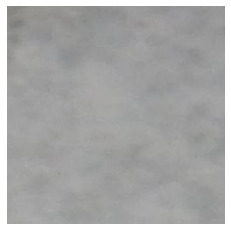

In [5]:
shuffle_buffer_size = len(files_train)

get_data_train = partial(get_data, files_train, augment=True)
dataset_train = tf.data.Dataset.from_generator(
    get_data_train, output_types=(tf.float32, tf.float32))
dataset_train = dataset_train.shuffle(shuffle_buffer_size).batch(batch_size)

get_data_val = partial(get_data, files_val, augment=False)
dataset_val = tf.data.Dataset.from_generator(
    get_data_val, output_types=(tf.float32, tf.float32))
dataset_val = dataset_val.batch(batch_size)

get_data_test = partial(get_data, files_test, augment=True)
dataset_test = tf.data.Dataset.from_generator(
    get_data_test, output_types=(tf.float32, tf.float32))
dataset_test = dataset_test.batch(batch_size)

X0, y0 = next(iter(dataset_train.batch(1)))
fig, ax = plt.subplots()
ax.imshow(X0.numpy()[0,0,:, :, :])
ax.set_axis_off()
plt.show()

In [6]:
cnn001 = CNN001(input_shape=input_shape, filters=filters, kernels=kernels, 
                droppath_prob=droppath_prob)
cnn001.build_graph(input_shape).summary()
cnn001.encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder (Functional)        (None, 512)               1569536   
                                                                 
 ffn (Functional)            (None, 256)               197120    
                                                                 
 classifier (Functional)     (None, 1)                 257       
                                                                 
Total params: 1,766,913
Trainable params: 1,762,689
Non-trainable params: 4,224
_________________________________________________________________
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [

In [7]:
cb1 = callbacks.EarlyStopping(monitor="val_loss", mode="min", verbose=0, 
                              patience=patience_early_stopping) 
cb2 = callbacks.ModelCheckpoint(
    "./model/", monitor="val_loss", save_best_only=True, 
    save_weights_only=True, verbose=0)
cb3 = MultiplicativeDecayWithReduceOrRestartOnPlateau(
    model=cnn001, lr_initial=lr_initial, lr_decay=lr_decay, 
    patience=patience_lr, factor_reduce=factor_reduce, 
    factor_restart=factor_restart, max_lr_restart=max_lr_restart, 
    restart_after_x_reductions=restart_after_x_reductions, 
    increment_restart_after_x_reductions=increment_restart_after_x_reductions)

cnn001.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(),
    metrics=[BinaryAccuracy(name="accuracy")])

history = cnn001.fit(
    dataset_train,
    verbose=1,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[cb1, cb2, cb3])

Epoch 1/125
86/86 [==============================] - 141s 1s/step - loss: 1.3354 - accuracy: 0.7135 - val_loss: 0.5932 - val_accuracy: 0.7837 - learning_rate: 3.0000e-04
Epoch 2/125
86/86 [==============================] - 116s 1s/step - loss: 0.5904 - accuracy: 0.7568 - val_loss: 0.5595 - val_accuracy: 0.7837 - learning_rate: 2.9100e-04
Epoch 3/125
86/86 [==============================] - 117s 1s/step - loss: 0.5597 - accuracy: 0.7699 - val_loss: 0.5254 - val_accuracy: 0.7842 - learning_rate: 2.8227e-04
Epoch 4/125
86/86 [==============================] - 117s 1s/step - loss: 0.5098 - accuracy: 0.7908 - val_loss: 0.5064 - val_accuracy: 0.7969 - learning_rate: 2.7380e-04
Epoch 5/125
86/86 [==============================] - 116s 1s/step - loss: 0.4805 - accuracy: 0.8101 - val_loss: 0.4645 - val_accuracy: 0.8129 - learning_rate: 2.6559e-04
Epoch 6/125
86/86 [==============================] - 117s 1s/step - loss: 0.4461 - accuracy: 0.8223 - val_loss: 0.4337 - val_accuracy: 0.8258 - learni

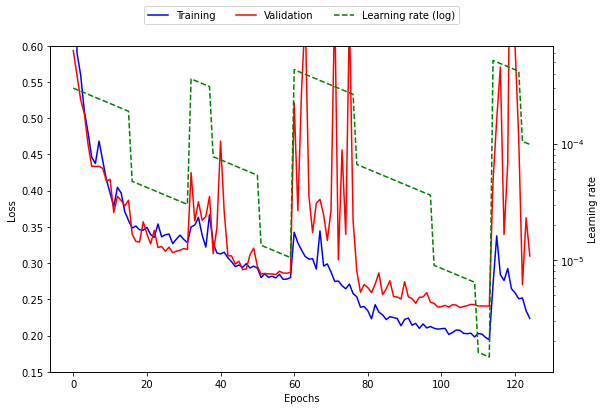

In [8]:
fig, ax_a = plt.subplots(figsize=(9, 6))
l1 = ax_a.plot(history.history["loss"], color="b", label="Training")
l2 = ax_a.plot(history.history["val_loss"], color="r", label="Validation")
ax_a.set_xlabel("Epochs")
ax_a.set_ylabel("Loss")
ax_a.set_ylim(0.15, 0.60)
ax_b = ax_a.twinx() 
l3 = ax_b.plot(history.history["learning_rate"], color="g", linestyle="dashed", 
               label="Learning rate (log)")
ax_b.set_ylabel("Learning rate")
ax_b.set_yscale("log")
ax_a.legend(l1+l2+l3, [l.get_label() for l in l1+l2+l3], loc="lower center", 
            bbox_to_anchor=(0, 1.05, 1, 0.2), ncol=3)        
plt.show()

142/142 [==============================] - 40s 283ms/step
Accuracy: 0.913
GBA score: 0.812


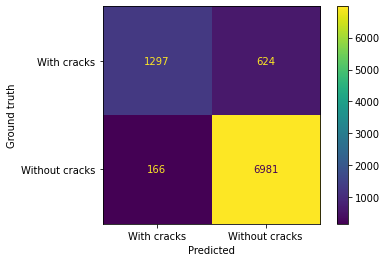

In [9]:
y_test = np.concatenate([y for x, y in dataset_test], axis=0)

cnn001 = CNN001(input_shape=input_shape, filters=filters, kernels=kernels,
                droppath_prob=droppath_prob)
cnn001.load_weights("./model/")
y_test_pred_probs = cnn001.predict(dataset_test)
y_test_pred = np.where(y_test_pred_probs > 0.5, 1, 0)

accuracy_test = accuracy_score(y_test, y_test_pred)
gba_test = gba_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy_test:.3f}")
print(f"GBA score: {gba_test:.3f}")

cm = confusion_matrix(y_test, y_test_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["With cracks", "Without cracks"])
plt.yticks([0,1], ["With cracks", "Without cracks"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()